In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.integrate as spi
plt.style.use('seaborn-white')
%matplotlib inline

In [2]:
filename = 'data/diff_lambdas_const_rh2.csv'
df = pd.read_csv(filename)
df.head()

,DL,DLS,DS,M,numerical_thetas,om_lambdas,rs,rs_initial,step,theta
0,622.435157,28.011834,645.108201,0.000001,0.000020,0.000000,780.827202,780.840451,5.000000e-07,0.000020
1,623.866125,28.133893,646.585402,0.000001,0.000020,0.020204,782.695601,782.705489,5.000000e-07,0.000020
2,625.309897,28.257652,648.164385,0.000001,0.000020,0.040408,784.576613,784.587842,5.000000e-07,0.000020
3,626.766685,28.383142,649.667598,0.000001,0.000019,0.060612,786.480337,786.487810,5.000000e-07,0.000019
4,628.236710,28.510400,651.279833,0.000001,0.000019,0.080816,788.396883,788.405701,5.000000e-07,0.000019


In [3]:
df.values[0]

array([  6.22435157e+02,   2.80118342e+01,   6.45108201e+02,
         1.43292288e-06,   1.99962629e-05,   0.00000000e+00,
         7.80827202e+02,   7.80840451e+02,   5.00000000e-07,
         2.00000000e-05])

In [4]:
# length_scale = 3.086e22
# H_0 = 7.56e-27 * length_scale
# M = 1474e12 / length_scale
# # print(M)
# print(4*M/201.990641/9.99960083e-06)
# Lambda = 3*0.726531*H_0**2
# print(Lambda*(201.990641*9.99960083e-06)**3/6/M)
# print(15*np.pi/4*M**2/(201.990641*9.99960083e-06)**2)

In [6]:
# df = df[~((df.om_lambdas < 0.707144) & (df.om_lambdas > 0.707142))]

length_scale = 3.086e22
H_0 = 7.56e-27 * length_scale
# M = 1474e12 / length_scale

# def calc_theta(D_LS, D_L, D_S):
#     return np.sqrt(4*M*D_LS/D_L/D_S)

theta_second_order = []
theta_rindler = []
for index, row in df.iterrows():
    Lambda = 3*row.om_lambdas*H_0**2
    M = row.M
    rho = (1-row.om_lambdas)*3*H_0**2/(8*np.pi)
    r_h = (3*M/(4*np.pi*rho))**(1./3)
    

#     row.DLS*Lambda*row.DL**3/6/M,
#     coeff = [row.DLS*Lambda*row.DL**3/6/M, 0, row.DS, 0, -4*M*row.DLS/row.DL, -15*np.pi*M**2/4*row.DLS/row.DL**2, -305/12*M**3*row.DLS/row.DL**3]
    coeff = [row.DS + Lambda*row.DL*row.DLS*r_h/3, 0, -4*M*row.DLS/row.DL, -15*np.pi*M**2/4*row.DLS/row.DL**2, -305/12*M**3*row.DLS/row.DL**3]
#     if index < 50:
#         print(row.om_lambdas, 15*np.pi/4*M**2/(row.DL*row.theta)**2, Lambda*(row.DL*row.theta)*r_h/3)
    roots = np.roots(coeff)
    roots = roots[roots>0 & np.isreal(roots)]
    th = np.real(roots)
    rindler = th[np.argmin(np.abs(row.theta - th))]

    # coeff2 = [row.DS, -4*M*row.DLS/row.DL, 8*M**3*row.DLS/row.DL**3]
    coeff2 = [row.DS, 0, -4*M*row.DLS/row.DL, -15*np.pi*M**2/4*row.DLS/row.DL**2, -401/12*M**3*row.DLS/row.DL**3]
    roots2 = np.roots(coeff2)
    roots2 = roots2[roots2>0 & np.isreal(roots2)]
    th2 = np.real(roots2)
    second_order = th2[np.argmin(np.abs(row.theta - th2))]
    theta_rindler.append(rindler)
    theta_second_order.append(second_order)
    
#     if 990 < index < 1000:
#         calculated_ds = row.DLS*(4*M/(row.DL*rindler) + 15*np.pi*M**2/4/(row.DL*rindler)**2 + 305/12*M**3/(row.DL*rindler)**3 - Lambda*(row.DL*rindler)**3/6/M)/rindler
#         print(row.om_lambdas)
#         print(row.DS, calculated_ds)
#         print((rindler - row.theta)/row.theta)
#         print("==")

df['theta_second_order'] = theta_second_order
df['theta_rindler'] = theta_rindler


# ## removed percentage!!

df['percentage_diff'] = (df.theta_second_order - df.theta)/df.theta
df['rindler_preds'] = (df.theta_rindler - df.theta)/df.theta

# df['percentage_diff'] = (df.theta_second_order - df.theta)/df.theta*100
# df['percentage_diff'] = (df.rs - df.rs_initial)/df.rs_initial*100

In [7]:
df.head()

,DL,DLS,DS,M,numerical_thetas,om_lambdas,rs,rs_initial,step,theta,theta_second_order,theta_rindler,percentage_diff,rindler_preds
0,622.435157,28.011834,645.108201,0.000001,0.000020,0.000000,780.827202,780.840451,5.000000e-07,0.000020,0.000020,0.000020,-0.000017,-0.000017
1,623.866125,28.133893,646.585402,0.000001,0.000020,0.020204,782.695601,782.705489,5.000000e-07,0.000020,0.000020,0.000020,0.000029,0.000029
2,625.309897,28.257652,648.164385,0.000001,0.000020,0.040408,784.576613,784.587842,5.000000e-07,0.000020,0.000020,0.000020,0.000008,0.000008
3,626.766685,28.383142,649.667598,0.000001,0.000019,0.060612,786.480337,786.487810,5.000000e-07,0.000019,0.000019,0.000019,0.000059,0.000059
4,628.236710,28.510400,651.279833,0.000001,0.000019,0.080816,788.396883,788.405701,5.000000e-07,0.000019,0.000019,0.000019,0.000039,0.000039


In [8]:
stats = df[['om_lambdas', 'percentage_diff', 'rindler_preds']].groupby('om_lambdas').agg(['mean', 'std', 'count'])
stats.columns = [' '.join(col).strip() for col in stats.columns.values]
stats['percentage_diff mean std'] = stats['percentage_diff std']/np.sqrt(stats['percentage_diff count'])
stats['rindler_preds mean std'] = stats['rindler_preds std']/np.sqrt(stats['rindler_preds count'])
stats

,percentage_diff mean,percentage_diff std,percentage_diff count,rindler_preds mean,rindler_preds std,rindler_preds count,percentage_diff mean std,rindler_preds mean std
om_lambdas,,,,,,,,
0.000000,7.267332e-05,0.000132,43,7.266792e-05,0.000132,43,0.000020,0.000020
0.020204,5.491025e-05,0.000119,43,5.474644e-05,0.000119,43,0.000018,0.000018
0.040408,5.205692e-05,0.000136,43,5.173230e-05,0.000136,43,0.000021,0.000021
0.060612,7.059394e-05,0.000145,43,7.010600e-05,0.000145,43,0.000022,0.000022
0.080816,6.440919e-05,0.000112,43,6.375542e-05,0.000112,43,0.000017,0.000017
0.101020,7.742013e-05,0.000128,43,7.659777e-05,0.000128,43,0.000019,0.000019
0.121224,4.227005e-05,0.000120,43,4.127653e-05,0.000120,43,0.000018,0.000018
0.141429,2.576535e-05,0.000115,43,2.459779e-05,0.000115,43,0.000018,0.000018
0.161633,5.588066e-05,0.000124,43,5.453581e-05,0.000123,43,0.000019,0.000019


In [9]:
stats.values[0]

array([  7.26733215e-05,   1.32159389e-04,   4.30000000e+01,
         7.26679215e-05,   1.32159955e-04,   4.30000000e+01,
         2.01541178e-05,   2.01542042e-05])

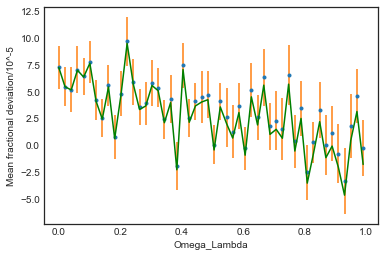

In [10]:
scale = 1e-5
plt.plot(stats.index, stats['percentage_diff mean']/scale, '.')
plt.errorbar(stats.index, stats['percentage_diff mean']/scale, yerr=stats['percentage_diff mean std']/scale, linestyle='none')
plt.xlabel('Omega_Lambda')
plt.ylabel('Mean fractional deviation/10^-5')
plt.plot(stats.index, stats['rindler_preds mean']/scale, 'g-')
# plt.savefig('fractional deviation.png')
# plt.errorbar(stats.index, stats['rindler_preds mean']/scale, yerr=stats['rindler_preds mean std']/scale, linestyle='none')

In [ ]:
from util import plot_diff_lambdas
plt.figure()
plt.title("vode")
plot_diff_lambdas('data/diff_lambdas_small2.csv', recalculate_distances=True)
plot_diff_lambdas('data/diff_lambdas_step.csv', plot_rindler=True)
plot_diff_lambdas('data/diff_lambdas_step2.csv')
plt.figure()
plt.title("dopri5")
plot_diff_lambdas('data/dopri5_diff_lambdas.csv')
plot_diff_lambdas('data/dopri5_diff_lambdas2.csv', plot_rindler=True)
plt.figure()
plt.title("dop853")
plot_diff_lambdas('data/dop853_diff_lambdas.csv')
plot_diff_lambdas('data/dop853_diff_lambdas2.csv')

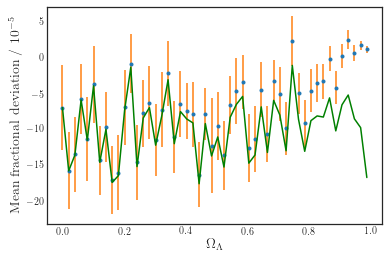

In [44]:
# configure plotting
import importlib
import util
util = importlib.reload(util)

from matplotlib import rc, rcParams
rc('text', usetex=True)
plt.rc('font', family='serif')
%config InlineBackend.rc = {'figure.dpi': 600, 'savefig.dpi': 300, \
                            'font.size': 30, \
                            'figure.facecolor': (1, 1, 1, 0)}
util.plot_diff_lambdas('data/diff_lambdas_bigger_redshifts2.csv', plot_rindler=True)
# ax = plt.gca()
plt.xlabel(u"$\Omega_{\Lambda}$", size=14)
plt.ylabel('Mean fractional deviation / $10^{-5}$', size=14)
# plt.legend()
# plt.savefig('images/fractional_deviations_const_M_without_rindler.png', dpi=400, transparent=True)